In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
augmented_train = pd.read_pickle('/content/drive/MyDrive/ravdess_train_augmented_mfcc.pkl')
test_data = pd.read_pickle('/content/drive/MyDrive/ravdess_test_mfcc.pkl')

In [ ]:
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
# ================================
# 6. Padding MFCCs
# ================================

X_train_raw = augmented_train['features'].tolist()
y_train_raw = augmented_train['emotion'].tolist()

X_test_raw = test_data['features'].tolist()
y_test_raw = test_data['emotion'].tolist()

maxlen = max(
    max([feat.shape[0] for feat in X_train_raw]),
    max([feat.shape[0] for feat in X_test_raw])
)

X_train_pad = pad_sequences(X_train_raw, padding='post', dtype='float32', maxlen=maxlen)
X_test_pad = pad_sequences(X_test_raw, padding='post', dtype='float32', maxlen=maxlen)

print("Train shape:", X_train_pad.shape)
print("Test shape:", X_test_pad.shape)

# ================================
# 7. Label Encoding
# ================================

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_raw)
y_test_encoded = le.transform(y_test_raw)

# (optional) for keras categorical
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train_encoded)
y_test_cat = to_categorical(y_test_encoded)


Train shape: (7856, 200, 40)
Test shape: (492, 200, 40)


In [ ]:
print(X_train_pad.shape)
print(X_test_pad.shape)
print(y_test_cat.shape)

(7856, 200, 40)
(492, 200, 40)
(492, 8)


In [ ]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)  # (batch_size, timesteps, 1)
        alpha = K.softmax(e, axis=1)  # attention weights
        context = x * alpha  # apply attention
        context = K.sum(context, axis=1)  # sum over time
        return context

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Masking
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GRU

model = Sequential()

# Mask padded values
model.add(Masking(mask_value=0., input_shape=(X_train_pad.shape[1], X_train_pad.shape[2])))

# 🔹 CNN Block 1
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

# 🔹 CNN Block 2
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

# 🔸 GRU with return_sequences
model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))

# 🎯 Attention Layer
model.add(Attention())

# 🔻 Dense Layers
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(y_train_cat.shape[1], activation='softmax'))  # num_classes

# 🔧 Compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 200, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 200, 64)        │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 100, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 256)        │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 256)            │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 253,754 (991.23 KB)

 Trainable params: 253,370 (989.73 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Optional callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    X_train_pad, y_train_cat,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_pad, y_test_cat),
    callbacks=[reduce_lr]  # you can add early_stop too
)

Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.2337 - loss: 2.1458 - val_accuracy: 0.4959 - val_loss: 1.5384 - learning_rate: 0.0010
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.4214 - loss: 1.7191 - val_accuracy: 0.6606 - val_loss: 1.1842 - learning_rate: 0.0010
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5344 - loss: 1.4734 - val_accuracy: 0.6728 - val_loss: 1.0183 - learning_rate: 0.0010
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5722 - loss: 1.3474 - val_accuracy: 0.6524 - val_loss: 1.0952 - learning_rate: 0.0010
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6009 - loss: 1.2470 - val_accuracy: 0.7012 - val_loss: 1.0016 - learning_rate: 0.0010
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6230 - loss: 1.2156 - val_accuracy: 0.7337 - val_loss: 0.9505 - learning_rate: 0.0010
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.6339 - 

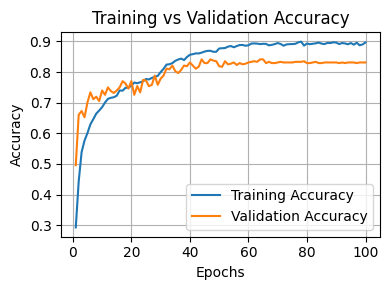

In [ ]:
import matplotlib.pyplot as plt

# Extract accuracy values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# Plot
plt.figure(figsize=(4, 3))
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

       angry       0.95      0.92      0.93        75
        calm       0.87      0.89      0.88        75
     disgust       0.87      0.87      0.87        39
     fearful       0.74      0.81      0.78        75
       happy       0.92      0.80      0.86        76
     neutral       0.70      0.82      0.76        38
         sad       0.75      0.73      0.74        75
   surprised       0.82      0.79      0.81        39

    accuracy                           0.83       492
   macro avg       0.83      0.83      0.83       492
weighted avg       0.84      0.83      0.83       492



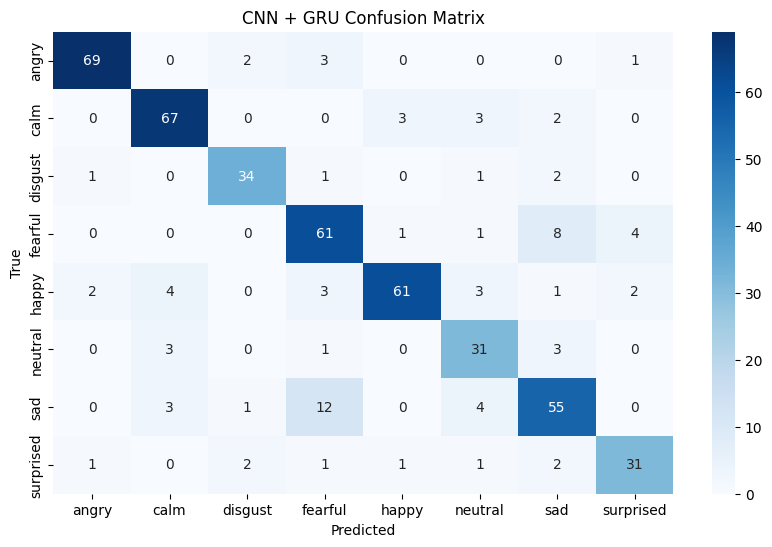

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict
y_pred = model.predict(X_test_pad)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_cat, axis=1)

# Report
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("CNN + GRU Confusion Matrix")
plt.show()


In [ ]:
model.save('/content/drive/MyDrive/MARS25/emotion_classifier_gru.h5')